# Facial Recognition Demo

In this notebook, I demonstrate a basic facial recognition pipeline. This is motivated by the fact that hashes are designed to uniquely identify their input files, but cannot determine if two different images/videos contain the same subject. To move from detecting existing CSAM to detecting new cases of it and linking together existing materials, a more flexible technology, such as one based on machine learning, will be required.

My initial solution involves training a [Siamese Neural Network](https://en.wikipedia.org/wiki/Siamese_neural_network) to detect if two images depict the same subject. One way to think about this is that the network learns a low-dimensional representation of images such that two images depicting the same subject will have similar representations. This is conceptually similar to that of a [Perceptual Hash](https://en.wikipedia.org/wiki/Perceptual_hashing), except that the compression function will be learned from data rather than being hand-designed.

This notebook includes the following libraries, among others:
* Tensorflow (2.0) for deep learning
* PIL for image processing

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from copy import copy
from PIL import Image
from tqdm.notebook import tqdm

## Data

I will be using the Yale Face database for this demo, in particular an [MIT-hosted mirror](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/) of the dataset. The dataset contains 165 images of 15 subjects (11 images each).

### Retrieval
The first step is to retrieve the data from the web. I have written a simple script that does just this.

In [2]:
download_dir = "./data/yale-faces/"

if not os.path.exists(download_dir):
    print("Retrieving data...")
    os.system("Python data/retrieve-yale-faces.py")
    print("Done.")
else:
    print("Data directory already exists. Remove and rerun cell if needed.")

Data directory already exists. Remove and rerun cell if needed.


### Inspection

In [3]:
img_dir = download_dir + "yalefaces/"
img_files = os.listdir(img_dir)

print(img_files[:11])
print(img_files[-11:])

['subject01.centerlight', 'subject01.glasses', 'subject01.happy', 'subject01.leftlight', 'subject01.noglasses', 'subject01.normal', 'subject01.rightlight', 'subject01.sad', 'subject01.sleepy', 'subject01.surprised', 'subject01.wink']
['subject15.centerlight', 'subject15.glasses', 'subject15.happy', 'subject15.leftlight', 'subject15.noglasses', 'subject15.normal', 'subject15.rightlight', 'subject15.sad', 'subject15.sleepy', 'subject15.surprised', 'subject15.wink']


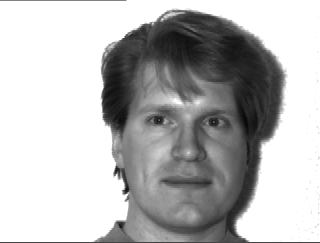

In [4]:
Image.open(img_dir + img_files[0])

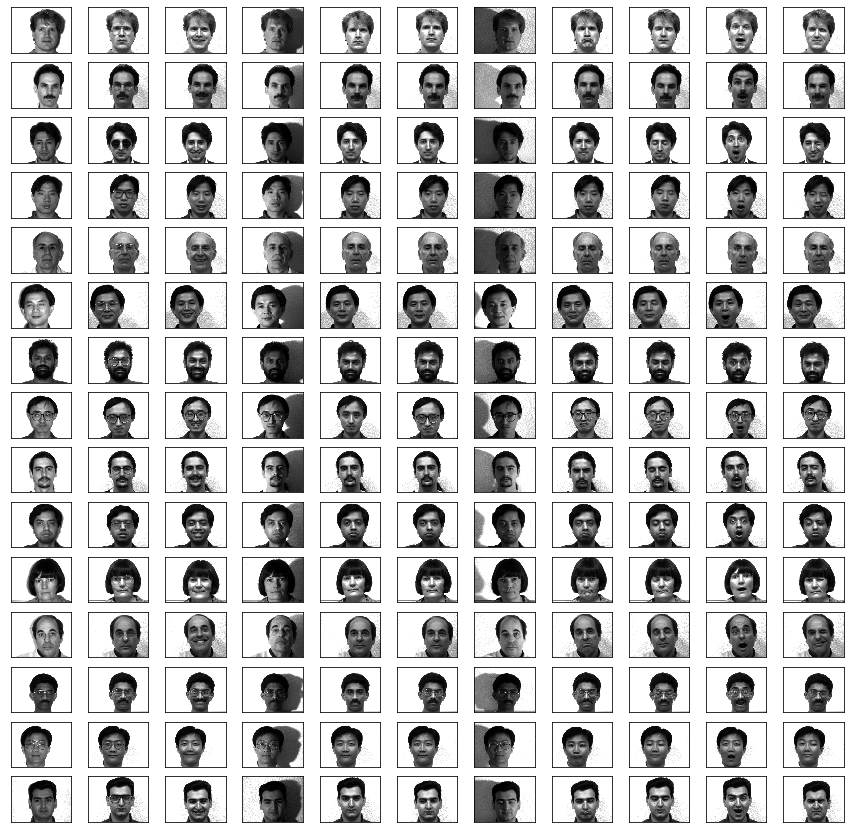

In [5]:
imgs = map(Image.open, [img_dir + f for f in img_files])

fig, axes = plt.subplots(nrows=15, ncols=11, figsize=(15, 15))
dims = []
for ax, img in zip(axes.flatten(), imgs):
    dims.append(img.size)
    ax.imshow(img, cmap="gray")
    ax.set(xticks=[], yticks=[])

In [6]:
print("Image dimensions: {}".format(np.unique(dims)))

Image dimensions: [243 320]


## Model

I will build a relatively shallow convolutional neural network with a dense layer for the embeddings. Note that in a workplace setting, I would very quickly want to move on to some sort of transfer learning approach instead of building from scratch, but in this case I would like to demonstrate proficiency with Tensorflow. For the same reason, I choose to use the "base" API instead of a higher level one such as Keras.

In the interest of streamlining this notebook, my source code for the model constructor is in a separate file. I highly recommend you examine it.

In [7]:
from custom_models import SiameseNetwork

### Training Flow and Data Partitioning

To train the Siamese network, we will need to feed it tuples of image files. This will require some custom training logic. Although this dataset is small enough to read into memory, I will implement a generator that reads files when they are needed, since this would scale to larger datasets.

Also, in order to get an estimate of the model's performance, some data will need to be held out. For a production model with a large dataset, I would partition the data into training, validation, and test sets. However, since today I don't plan to tune hyperparameters, I will simply partition the data into training and test sets.

* Training set: Subjects 1-12
* Test set: Subjects 13-15

I will also hold out two images from each of subjects 1-12 in order to examine the performance of the model when it has trained on an individual and is encountering a new image of that individual.

In [8]:
np.random.seed(41)

In [9]:
train_imgs = [{"subject": f[7:9], "file": img_dir + f} for f in img_files[:-33]]
test_imgs = [{"subject": f[7:9], "file": img_dir + f} for f in img_files[-33:]]

extra_holdouts = np.array([np.random.choice(range(1, 12), 2, replace=False) for _ in range(12)])
extra_holdouts = np.ravel(extra_holdouts + np.arange(0, len(train_imgs), 11)[:, np.newaxis]) - 1

test_imgs = test_imgs + [train_imgs[ix] for ix in extra_holdouts]
train_imgs = [img for img in train_imgs if img not in test_imgs]

In [10]:
def batch_generator(imgs, pos_samples=8, neg_samples=8):
    imgs = copy(imgs)
    np.random.shuffle(imgs)
    for img in imgs:
        subject = img["subject"]

        # tf model expects batch dimensions and channel dimension
        x1 = np.array(Image.open(img["file"]))[np.newaxis, :, :, np.newaxis]
        
        # min-max normalization for image data is dividing by 255
        X1 = np.tile(x1, (pos_samples + neg_samples, 1, 1, 1)) / 255
        labels = np.concatenate((np.repeat(1, pos_samples), np.repeat(0, neg_samples)))
        
        same_subject = [i for i in imgs if i["subject"] == subject and i != img]
        different_subject = [i for i in imgs if i["subject"] != subject]
                
        pos = np.random.choice(same_subject, pos_samples, replace=False)
        X2_pos = np.array([np.array(Image.open(s["file"])) for s in pos])
        
        neg = np.random.choice(different_subject, neg_samples, replace=False)
        X2_neg = np.array([np.array(Image.open(s["file"])) for s in neg])
        
        X2 = np.concatenate((X2_pos, X2_neg))[:, :, :, np.newaxis] / 255
        
        assert X1.max() <= 1 and X2.max() <= 1, "Images improperly scaled."
            
        yield X1, X2, np.expand_dims(labels, -1)

### Training

For now, I will train the model on one full pass through the data. It will actually see every image more than once, because for every "anchor" image, positive and negative images are sampled, representing images depicting the same subject as the anchor and a different subject respectively.

In [11]:
epochs = 5
checkpoint_dir = "./checkpoints_20191230_2/"

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [12]:
optimizer_args = {"learning_rate": 1e-3, "epsilon": 0.1, "beta_1": 0.8, "beta_2": 0.95}
model = SiameseNetwork(checkpoint_dir=checkpoint_dir, **optimizer_args)

In [13]:
mean_abs_gradients = []
losses = []
best_loss = np.inf
for epoch in range(epochs):
    train_generator = batch_generator(train_imgs)
    
    for X1, X2, labels in tqdm(train_generator, total=len(train_imgs)):
        grads, loss = model.train_step(X1, X2, labels)

        mean_grads = [np.round(np.abs(g.numpy()).mean(), 5) for g in grads]
        mean_abs_gradients.append(mean_grads)
        assert not np.isnan(loss)
        losses.append(float(loss))
        print("loss: {:.3f}, mean gradients: {}\t\t".format(loss, mean_grads), end="\r")
        
    model.save("epoch{}_trainloss{:.2f}".format(epoch + 1, np.mean(losses)))

loss: 0.344, mean gradients: [0.07034, 0.00467, 0.00073, 0.07424, 0.00236]		
Checkpoint saved to ./checkpoints_20191230_2/epoch1_trainloss0.52


KeyboardInterrupt: 

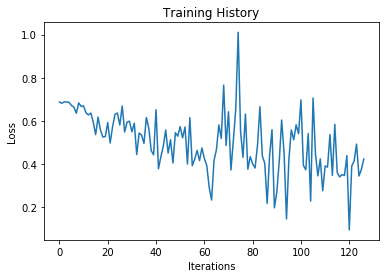

In [14]:
plt.plot(losses)
plt.title("Training History")
plt.xlabel("Iterations")
plt.ylabel("Loss");

## Results

To examine the performance of the model, I will use it in the way it would be used in a product: to match images against an internal database. For companies with facial-recognition security, this database would contain employee faces. For anti-CSAM technology, this database would probably contain the embeddings of known victims (and probably not the images themselves for privacy reasons).

My database will consist of subjects 1-10. Thus, there will be 3 measures of performance worth looking at:
1. Does the model correctly match an unseen image with a subject in the database?
2. Does the model correctly return no matches if an unseen image does not contain a subject in the database?
3. Does the model correctly identify 2 unseen images as containing the same or different subjects?

For the testing on unseen images, I will exhaustively check all pairs and report the proportion of correct classifications (match/no-match) as an accuracy percentage.

In [15]:
class EmbeddingDatabase(object):
    """Stores embeddings of subjects for lookup and comparison."""
    
    def __init__(self, model):
        """Assign model, initialize subjects dict."""
        self.model = model
        self.subjects = defaultdict(lambda: [])
    
    def add_subject(self, name, img):
        """Embed and store an image of a subject."""
        assert len(img.shape) in [2, 4], "Unexpected image shape."
        
        if len(img.shape) == 2:
            img = img[np.newaxis, :, :, np.newaxis]
        
        embedding = self.model.embed(img / 255)
        
        self.subjects[name].append(embedding)
        
    def lookup(self, query_img, method="mean", threshold=0.5):
        """See if the embedding of a query image matches a stored embedding."""
        assert len(query_img.shape) in [2, 4], "Unexpected image shape."
        assert method in ["mean", "max"], '`method` must be "mean" or "max"'
        
        if len(query_img.shape) == 2:
            query_img = query_img[np.newaxis, :, :, np.newaxis]
        
        max_score = 0 
        query_embed = self.model.embed(query_img / 255)
        for name, embeddings in self.subjects.items():
            scores = []
            for embed in embeddings:
                score = self.model.similarity_score(query_embed, embed, embed=False, logits=False)
                
                scores.append(score)
            
            test_score = np.mean(scores) if method == "mean" else np.max(scores)
            
            if test_score > max_score:
                max_score = test_score
                match = name
        
        if max_score <= threshold:
            match = "No match"

        return match, max_score

In [16]:
database = EmbeddingDatabase(model)

database_imgs = [img for img in train_imgs if int(img["subject"]) <= 10]

for img in database_imgs:
    database.add_subject(img["subject"], np.array(Image.open(img["file"])))

### 1. Holdout images of subjects 1-10 (in database)

Since multiple embeddings per subject are stored in the database, I have implemented two methods of returning a match. Using the "max" method, the the subject with the highest match (on any of its stored images) is returned when a query image is supplied, while using the "mean" method, the subject which has the highest mean similarity to the query image over all of its stored images is returned. This should give the system more robustness.

On this task, doing no better than random would amount to getting around 10% - a little less due to the chance of returning  "No match."

In [17]:
def match_images(database, imgs, method="mean"):
    correct_subject = []
    matched_subject = []
    match_scores = []
    
    for img in imgs:
        correct_subject.append(img["subject"])
        match, score = database.lookup(np.array(Image.open(img["file"])), method)
        
        matched_subject.append(match)
        match_scores.append(score)
        
    return correct_subject, matched_subject, match_scores

In [18]:
test_imgs_1_10 = [img for img in test_imgs if int(img["subject"]) <= 10]

correct_mean, matched_mean, scores_mean = match_images(database, test_imgs_1_10, "mean")
correct_max, matched_max, scores_max = match_images(database, test_imgs_1_10, "max")

In [20]:
result_mean = np.char.equal(correct_mean, matched_mean)
print('Accuracy (method = "mean"): {:.0f}%'.format(100 * result_mean.mean()))

result_max = np.char.equal(correct_max, matched_max)
print('Accuracy (method = "max"):  {:.0f}%'.format(100 * result_max.mean()))

if np.mean(result_mean) > 0:
    print("Mean similarity score (correctly recognized):",   np.array(scores_mean)[result_mean].mean())

if np.mean(result_mean) < 1:
    print("Mean similarity score (incorrectly recognized):", np.array(scores_mean)[~ result_mean].mean())

Accuracy (method = "mean"): 65%
Accuracy (method = "max"):  55%
Mean similarity score (correctly recognized): 0.67236274
Mean similarity score (incorrectly recognized): 0.656476


### 2. Holdout images of subjects 11-12 (not in database)

On this task, doing no better than random results in an even lower accuracy, given some assumptions. If random is defined as sampling a similarity score from a uniform distribution from [0, 1] for all images in the database, then the probability of returning "No match" is $0.5^{10}$, which is less than 0.1%. If instead we define random as choosing a subject in the database, or "No match" with equal probability, then random performance would be $\frac{1}{11}$, or around 9%.

In [21]:
test_imgs_11_12 = [img for img in test_imgs if img["subject"] in ["11", "12"]]

correct = ["No match" for _ in range(len(test_imgs_11_12))]
_, matched_mean, scores_mean = match_images(database, test_imgs_11_12, "mean")
_, matched_max, scores_max = match_images(database, test_imgs_11_12, "max")

In [22]:
result_mean = np.char.equal(correct, matched_mean)
print('Accuracy (method="mean"): {:.0f}%'.format(100 * result_mean.mean()))

result_max = np.char.equal(correct, matched_max)
print('Accuracy (method="max"):  {:.0f}%'.format(100 * result_max.mean()))

if np.mean(result_mean) > 0:
    print("Mean similarity score (correctly recognized):",   np.array(scores_mean)[result_mean].mean())

if np.mean(result_mean) < 1:
    print("Mean similarity score (incorrectly recognized):", np.array(scores_mean)[~ result_mean].mean())

Accuracy (method="mean"): 25%
Accuracy (method="max"):  25%
Mean similarity score (correctly recognized): 0.14083868
Mean similarity score (incorrectly recognized): 0.66309017


### 3. Remainder of holdout set (subjects 13-15)

In [23]:
test_imgs_13_15 = [img for img in test_imgs if int(img["subject"]) >= 13]

correct = ["No match" for _ in range(len(test_imgs_13_15))]
_, matched_mean, scores_mean = match_images(database, test_imgs_13_15, "mean")
_, matched_max, scores_max = match_images(database, test_imgs_13_15, "max")

In [24]:
result_mean = np.char.equal(correct, matched_mean)
print('Accuracy (method="mean"): {:.0f}%'.format(100 * result_mean.mean()))

result_max = np.char.equal(correct, matched_max)
print('Accuracy (method="max"):  {:.0f}%'.format(100 * result_max.mean()))

if np.mean(result_mean) > 0:
    print("Mean similarity score (correctly recognized):",   np.array(scores_mean)[result_mean].mean())

if np.mean(result_mean) < 1:
    print("Mean similarity score (incorrectly recognized):", np.array(scores_mean)[~ result_mean].mean())

Accuracy (method="mean"): 3%
Accuracy (method="max"):  0%
Mean similarity score (correctly recognized): 0.49500784
Mean similarity score (incorrectly recognized): 0.6313081


### 4. Matching subjects 13-15 with each other (3-way holdout accuracy)

To mimic the system above, temporary databases will be constructed for each subject. This is a valid estimate of the ability of the Siamese Network to generalize, because it has not seen any of the images. Decent performance on this set of images shows that the distance function learned is able to find and exploit useful features.

Note that this method also means that computations will take a little longer.

On this task, random performance is around $\frac{1}{3}$, or 33%.

In [26]:
correct = []
matched_mean = []
matched_max = []
scores_mean = []
scores_max = []

subjects = ["13", "14", "15"]
for subject in tqdm(subjects):
    subject_imgs = [img for img in test_imgs if img["subject"] == subject]
    
    other_subjects = copy(subjects)
    other_subjects.remove(subject)
    non_subject_imgs = [img for img in test_imgs if img["subject"] in other_subjects]

    for i in tqdm(range(len(subject_imgs))):
        database_imgs = copy(subject_imgs) + non_subject_imgs
        test_img = database_imgs.pop(i)

        database = EmbeddingDatabase(model)

        for img in database_imgs:
            database.add_subject(img["subject"], np.array(Image.open(img["file"])))
        
        match_mean, score_mean = database.lookup(np.array(Image.open(test_img["file"])), method="mean")
        match_max, score_max = database.lookup(np.array(Image.open(test_img["file"])), method="max")
        
        correct.append(subject)
        matched_mean.append(match_mean)
        matched_max.append(match_max)
        scores_mean.append(score_mean)
        scores_max.append(score_max)

In [27]:
result_mean = np.char.equal(correct, matched_mean)
print('Accuracy (method = "mean"): {:.0f}%'.format(100 * result_mean.mean()))

result_max = np.char.equal(correct, matched_max)
print('Accuracy (method = "max"):  {:.0f}%'.format(100 * result_max.mean()))

if np.mean(result_max) > 0:
    print("Mean similarity score (correctly recognized):",   np.array(scores_max)[result_max].mean())

if np.mean(result_max) < 1:
    print("Mean similarity score (incorrectly recognized):", np.array(scores_max)[~ result_max].mean())

Accuracy (method = "mean"): 30%
Accuracy (method = "max"):  36%
Mean similarity score (correctly recognized): 0.7689081
Mean similarity score (incorrectly recognized): 0.87711537


## Commentary

## Conclusion

A few problems I encountered along the way:
* NaNs caused by tf.norm, use tf.abs
* Vanishing gradients: from_logits=True solves problem? (epsilon for optimizer)